## Skin Deep Learning Training with Data Augmentation

In [1]:
# Import libraries
import keras as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import tensorflow as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa


Using TensorFlow backend.


In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading and Preprocessing data

In [0]:
 X, y, m, ny, nx, nc = np.load('gdrive/My Drive/Google Colab Data/Skin/temp.npy')

### Data Augmentation

We have a lot of data for "Melanocytic nevi" - class 4, but not so much for all the others. Let's try using data augmentation to increase the number of samples with are not class 4 to help the model learn to generalize.

In [0]:
# Define a sequence for augmentation
seq = iaa.SomeOf(3, [
    iaa.Flipud(0.5), # vertically flip 50% of the images
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 0.5)), # blur images with a sigma of 0 to 0.5
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)),
    iaa.Sharpen(alpha=0.5),
    iaa.CropAndPad(percent=(-0.25, 0.25))
    ],random_order=True) # apply augmenters in random order

In [0]:
# create additional data set by augmentation
X_aug = seq.augment_images(X)

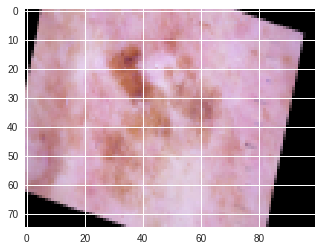

In [6]:
plt.imshow(X_aug[0])

In [7]:
# Take only images which don't belong to class 4
X_aug_not4 = np.squeeze(X_aug[np.where(y!=4),:,:,:])
y_aug_not4 = np.squeeze(y[np.where(y!=4)])
print(X_aug_not4.shape, y_aug_not4.shape)

(3310, 75, 100, 3) (3310,)


In [0]:
# Total data set with augmentation
# X_tot = np.concatenate((X,X_aug_not4), axis=0)
# y_tot = np.concatenate((y,y_aug_not4))

X_tot = np.concatenate((X,X_aug), axis=0)
y_tot = np.concatenate((y,y))

#### Randomizing and Normalizing DataFrame

In [0]:
#Randomizing and splitting the data set
train_X, test_X, train_y, test_y = train_test_split(X_tot, y_tot, \
test_size=0.10, random_state=3)
#Converting test and train y to one hot encode format
test_y = K.utils.to_categorical(test_y.transpose())
train_y = K.utils.to_categorical(train_y.transpose())


In [0]:
#Calculating train_X mean and standard deviation for normalization
train_X_mean = np.mean(train_X, axis=0)
train_X_std = np.std(train_X, axis=0)

#Normalization

train_X = ((train_X - train_X_mean)/train_X_std)
test_X = ((test_X - train_X_mean)/train_X_std)
#No variable generation for test set to prevent data leakage

### Model Building

Created model using sequential feed. Model utilies a pair of convolutional layers with 32 filters each followed by a
max pooling layer. We use dropout for regularization to avoid overfitting the model.

We repeat the above step with more granular convolutional filters. We again use dropout with a more aggressive
dropout rate to avoid overfitting the model.

We add a dense layer using the rectified linear unit as the activation function. Regularization is applied again to 
limit overfitting.

Softmax activation layer is used to predict the 7 disease categories identified by our dataset.

In [16]:
# Setting CNN Skin model

input_shape = (ny, nx, nc)
kernel_size = 3
class_num = 7

model = K.models.Sequential()
model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(128, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(Conv2D(128, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(class_num, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [0]:
# Define optimizer (Adam optimizer)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,\
                              epsilon=None, decay=0.0, amsgrad=False)

In [0]:
# Compile the model, categorical crossentropy loss and accuracy metric
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", \
             metrics = ['accuracy'])

In [19]:
history = model.fit(train_X, train_y, batch_size = 64, epochs = 25, validation_split = .2)

Train on 14421 samples, validate on 3606 samples
Epoch 1/25
14421/14421 [==============================] - 32s 2ms/step - loss: 1.0111 - acc: 0.6671 - val_loss: 0.9491 - val_acc: 0.6697
Epoch 2/25
14421/14421 [==============================] - 31s 2ms/step - loss: 0.8858 - acc: 0.6727 - val_loss: 0.8554 - val_acc: 0.6841
Epoch 3/25
14421/14421 [==============================] - 31s 2ms/step - loss: 0.8463 - acc: 0.6816 - val_loss: 0.8095 - val_acc: 0.6875
Epoch 4/25
14421/14421 [==============================] - 31s 2ms/step - loss: 0.8166 - acc: 0.6932 - val_loss: 0.7730 - val_acc: 0.7035
Epoch 5/25
14421/14421 [==============================] - 31s 2ms/step - loss: 0.7904 - acc: 0.7077 - val_loss: 0.7562 - val_acc: 0.7180
Epoch 6/25
14421/14421 [==============================] - 31s 2ms/step - loss: 0.7596 - acc: 0.7199 - val_loss: 0.7243 - val_acc: 0.7327
Epoch 7/25
14421/14421 [==============================] - 31s 2ms/step - loss: 0.7262 - acc: 0.7294 - val_loss: 0.6996 - val_acc:

<function matplotlib.pyplot.tight_layout>

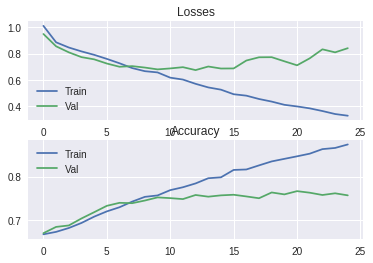

In [20]:
# Plotting training history
plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses')
plt.legend(['Train', 'Val'])

plt.subplot(2,1,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['Train', 'Val'])
plt.tight_layout

In [21]:
model.evaluate(test_X, test_y)

2003/2003 [==============================] - 2s 1ms/step


[0.8292736169313468, 0.752371442686958]

In [17]:
confusion_matrix(np.argmax(test_y, axis=1), np.argmax(model.predict(test_X), axis=1))

array([[ 17,  23,  16,   0,   5,  11,   0],
       [  9,  43,  20,   1,  13,   9,   0],
       [ 10,  19,  99,   0,  46,  38,   1],
       [  1,   5,   2,   4,   5,   3,   0],
       [  2,   3,  24,   0, 629,  26,   1],
       [  1,  10,  31,   0,  41, 133,   0],
       [  1,   5,   2,   1,   6,   3,  14]])

In [0]:
#Saving the model and weights for the end to end solution.

#Save weights
model.save_weights("gdrive/My Drive/Google Colab Data/Skin/skinmodelweights.h5")
model_json = model.to_json()

#Save model
with open("gdrive/My Drive/Google Colab Data/Skin/skinmodel.json", "w") as file:
  file.write(model_json)
  
#Save mean and std
np.save("gdrive/My Drive/Google Colab Data/Skin/skinmodel_meanstd.npy", [train_X_mean, train_X_std])
  


In [0]:
def img_processor(imgpath, meanstdpath, modelpath, weightspath):
  """
  inputs: 
        imgpath - path to image of potential skin cancer mole;
        meanstdpath - path to training mean & standard deviation;
        modelpath - path to Keras model;
        weightspath - path to weights for Keras model
  
  output: pred_dic - a prediction dictionary with diseases as keys and probabilities as values
  """
  
  from keras.models import model_from_json
  # load model
  with open(modelpath, "r") as file:
    loaded_json = file.read()
  skinmodel = model_from_json(loaded_json)

  # Load weights from file
  skinmodel.load_weights(weightspath)
  
  # Load mean and std
  train_X_mean, train_X_std = np.load(meanstdpath)
  
  # Loading, resizing image as np.array
  imagearray = np.asarray(Image.open(imgpath).resize((100,75)))
  imagearray = ((imagearray-train_X_mean)/train_X_std)
  ny, nx, nc = imagearray.shape
  imagearray = imagearray.reshape(1 ,ny, nx, nc)
                
  pred_vec = skinmodel.predict(imagearray).flatten()
  
  pred_dict = {'Actinic keratoses' : pred_vec[0], 'Basal cell carcinoma' : pred_vec[1],
                   'Benign keratosis-like lesions' : pred_vec[2], 'Dermatofibroma' : pred_vec[3],
                   'Melanocytic nevi' : pred_vec[4], 'Melanoma' : pred_vec[5], 'Vascular lesions' : pred_vec[6]
              }
                                      
  
  return pred_dict
  

In [20]:
drive_path = 'gdrive/My Drive/Google Colab Data/Skin/'
res = img_processor(drive_path + "HAM10000_images_part_1/ISIC_0024346.jpg", drive_path + "skinmodel_meanstd.npy",\
              drive_path + "skinmodel.json", drive_path + "skinmodelweights.h5")
print(res)

{'Actinic keratoses': 7.695745e-09, 'Basal cell carcinoma': 1.148513e-07, 'Benign keratosis-like lesions': 8.511569e-07, 'Dermatofibroma': 3.215808e-07, 'Melanocytic nevi': 0.9999981, 'Melanoma': 6.41248e-07, 'Vascular lesions': 1.3322557e-10}
